In [37]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import os

from sklearn.datasets import fetch_covtype, load_iris
import torchvision
import torchvision.transforms as transforms
import torch

from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tqdm
from baselineClassifierNN import SimpleMLP
from DynamicClassifierNN import DynamicMLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from itertools import product
import json
from training import train_complex_model, train_model, plot_learning_curves
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seed = 42

Using device: cpu


In [38]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['axes.labelsize'] = 12  # Academic font size for axis labels
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.titlesize'] = 14
figsize = (8, 6) 

In [39]:
data_dir = "../data"
results_dir = "../results"

In [40]:
random.seed(seed)  # Set seed for Python's random module
np.random.seed(seed)  # Set seed for NumPy
torch.manual_seed(seed)  # Set seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)  # Set seed for CUDA (single GPU)
    torch.cuda.manual_seed_all(seed)  # Set seed for CUDA (all GPUs)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False

# Get datasets section

In [41]:
iris = load_iris()

X = iris.data  
y = iris.target    
df_iris = pd.DataFrame(X, columns=iris.feature_names)
df_iris['label'] = y
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [42]:
# Randomly split iris dataset into 80% train and 20% test
df_iris_shuffled = df_iris.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.7 * len(df_iris_shuffled))
df_iris_train = df_iris_shuffled.iloc[:split_idx].copy()
df_iris_test = df_iris_shuffled.iloc[split_idx:].copy()

print("Train shape:", df_iris_train.shape)
print("Test shape:", df_iris_test.shape)
df_iris_train

Train shape: (105, 5)
Test shape: (45, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1
...,...,...,...,...,...
100,4.6,3.1,1.5,0.2,0
101,5.1,3.5,1.4,0.3,0
102,4.4,3.0,1.3,0.2,0
103,6.3,2.5,4.9,1.5,1


### Covtype dataset

In [43]:
data_cov = fetch_covtype(as_frame=True)
df_covtype = data_cov.frame 

df_covtype['Cover_Type'] = df_covtype['Cover_Type'] - 1
df_covtype['Aspect_sin'] = np.sin(np.deg2rad(df_covtype['Aspect']))
df_covtype['Aspect_cos'] = np.cos(np.deg2rad(df_covtype['Aspect']))
df_covtype = df_covtype.drop(columns=['Aspect'])


X_cov_type = df_covtype.drop('Cover_Type', axis=1).values
y_cov_type = df_covtype['Cover_Type'].values

print("Covtype dataset loaded.")
print(f"Covtype features shape: {X_cov_type.shape}, Covtype labels shape: {y_cov_type.shape}")

Covtype dataset loaded.
Covtype features shape: (581012, 55), Covtype labels shape: (581012,)


In [44]:
df_covtype.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2596.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.777146,0.629320
1,2590.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.829038,0.559193
2,2804.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.656059,-0.754710
3,2785.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.422618,-0.906308
4,2595.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.707107,0.707107


### Fashion-MNIST dataset

In [45]:

# Download and load Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True,  
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Convert train_dataset to DataFrame
train_images = []
train_labels = []

for img, label in train_dataset:
    train_images.append(img.numpy().flatten())
    train_labels.append(label)

df_train_fashion = pd.DataFrame(train_images)
df_train_fashion['label'] = train_labels

# Convert test_dataset to DataFrame
test_images = []
test_labels = []

for img, label in test_dataset:
    test_images.append(img.numpy().flatten())
    test_labels.append(label)

df_test_fashion = pd.DataFrame(test_images)
df_test_fashion['label'] = test_labels

print("Fashion-MNIST dataset loaded.")
print(f"Fashion-MNIST train shape: {df_train_fashion.shape}, Fashion-MNIST test shape: {df_test_fashion.shape}")
df_train_fashion.head()


Fashion-MNIST dataset loaded.
Fashion-MNIST train shape: (60000, 785), Fashion-MNIST test shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [46]:
# what is the class distribution for each dataset
print("Iris class distribution:\n", pd.Series(df_iris_train['label']).value_counts().sort_index())
print("Covtype class distribution:\n", pd.Series(y_cov_type).value_counts().sort_index())
print("Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Iris class distribution:
 label
0    40
1    33
2    32
Name: count, dtype: int64
Covtype class distribution:
 0    211840
1    283301
2     35754
3      2747
4      9493
5     17367
6     20510
Name: count, dtype: int64
Fashion-MNIST class distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [47]:
# take away 15 entries from class label in iris
for i in range(1, 3):
    index_to_drop = df_iris_train[df_iris_train['label'] == i].index[0]
    df_iris_train = df_iris_train.drop(df_iris_train[df_iris_train['label'] == i].index[:10*i])
print("Updated Iris class distribution:\n", pd.Series(df_iris_train['label']).value_counts().sort_index())

Updated Iris class distribution:
 label
0    40
1    23
2    12
Name: count, dtype: int64


In [48]:
# take away 1000 entries from class label 0 in fashion mnist
for i in range(0, 10):
    index_to_drop = df_train_fashion[df_train_fashion['label'] == i].index[0]
    df_train_fashion = df_train_fashion.drop(df_train_fashion[df_train_fashion['label'] == i].index[:500*i])
print("Updated Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Updated Fashion-MNIST class distribution:
 label
0    6000
1    5500
2    5000
3    4500
4    4000
5    3500
6    3000
7    2500
8    2000
9    1500
Name: count, dtype: int64


### Prepare each dataset for training and testing

## Iris dataset

In [49]:
X_train_iris_init = df_iris_train.drop('label', axis=1)
y_train_iris = df_iris_train['label']

X_test_iris_init = df_iris_test.drop('label', axis=1)
y_test_iris = df_iris_test['label']

X_train_iris = torch.tensor(X_train_iris_init.values, dtype=torch.float32).to(device)
y_train_iris = torch.tensor(y_train_iris.values, dtype=torch.long).to(device)
X_test_iris = torch.tensor(X_test_iris_init.values, dtype=torch.float32).to(device)
y_test_iris = torch.tensor(y_test_iris.values, dtype=torch.long).to(device)

### Covtype dataset

In [50]:
# take df_cover and build a single data frame for train and test. Have a 70-30 split. 
df_shuffled = df_covtype.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.7 * len(df_shuffled))

# Split into train and test
df_train_cov = df_shuffled.iloc[:split_idx].copy()
df_test_cov = df_shuffled.iloc[split_idx:].copy()
df_validation_cov = df_train_cov.sample(frac=0.3, random_state=42)
df_train_cov = df_train_cov.drop(index=df_validation_cov.index).reset_index(drop=True)
df_validation_cov = df_validation_cov.reset_index(drop=True)
df_test_cov = df_test_cov.reset_index(drop=True)

df_train_cov.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2732.0,7.0,212.0,1.0,1082.0,231.0,236.0,137.0,912.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.777146,-0.629320
1,2824.0,13.0,417.0,39.0,3223.0,233.0,214.0,110.0,6478.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.933580,0.358368
2,2529.0,5.0,120.0,9.0,1092.0,227.0,231.0,139.0,4983.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994522,0.104528
3,2050.0,42.0,170.0,141.0,192.0,75.0,201.0,246.0,255.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,-0.970296,0.241922
4,3141.0,6.0,503.0,72.0,240.0,228.0,241.0,147.0,1354.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.406737,-0.913545


In [51]:
scaler = StandardScaler()
df_train_cov_scaled = scaler.fit_transform(df_train_cov.drop('Cover_Type', axis=1))
df_test_cov_scaled = scaler.transform(df_test_cov.drop('Cover_Type', axis=1))
df_validation_cov_scaled = scaler.transform(df_validation_cov.drop('Cover_Type', axis=1))

df_train_cov_scaled = pd.DataFrame(df_train_cov_scaled, columns=df_train_cov.drop('Cover_Type', axis=1).columns)
df_train_cov_scaled['label'] = df_train_cov['Cover_Type'].values
df_validation_cov_scaled = pd.DataFrame(df_validation_cov_scaled, columns=df_validation_cov.drop('Cover_Type', axis=1).columns)
df_validation_cov_scaled['label'] = df_validation_cov['Cover_Type'].values
df_test_cov_scaled = pd.DataFrame(df_test_cov_scaled, columns=df_test_cov.drop('Cover_Type', axis=1).columns)
df_test_cov_scaled['label'] = df_test_cov['Cover_Type'].values

X_train_cov = torch.tensor(df_train_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_train_cov = torch.tensor(df_train_cov_scaled['label'].values, dtype=torch.long).to(device)

X_validation_cov = torch.tensor(df_validation_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation_cov = torch.tensor(df_validation_cov_scaled['label'].values, dtype=torch.long).to(device)

X_test_cov = torch.tensor(df_test_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_cov = torch.tensor(df_test_cov_scaled["label"].values, dtype=torch.long).to(device)



print("Covtype train and test DataFrames created.")
print(f"Covtype train shape: {df_train_cov_scaled.shape}, Covtype test shape: {df_test_cov_scaled.shape}, Covtype validation shape: {df_validation_cov_scaled.shape}")
df_train_cov_scaled.head()

Covtype train and test DataFrames created.
Covtype train shape: (284696, 56), Covtype test shape: (174304, 56), Covtype validation shape: (122012, 56)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label
0,-0.810111,-0.947044,-0.267767,-0.779034,-0.811772,0.705564,0.641559,-0.147932,-0.806385,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.875461,-1.168007,1
1,-0.481563,-0.147008,0.697251,-0.126014,0.562346,0.780021,-0.472742,-0.853676,3.406391,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.106044,0.264724,1
2,-1.535061,-1.213723,-0.700849,-0.641556,-0.805354,0.556648,0.388309,-0.095655,2.274861,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.195871,-0.103493,1
3,-3.245657,3.719833,-0.465478,1.626829,-1.382984,-5.102140,-1.131192,2.701184,-1.303653,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.700256,0.095809,2
4,0.650502,-1.080384,1.102088,0.441083,-1.352177,0.593877,0.894809,0.113455,-0.471845,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.329480,-1.580302,1


### Fashion-MNIST dataset

In [52]:
X_train_fashion_init = df_train_fashion.drop('label', axis=1)
y_train_fashion = df_train_fashion['label']

X_train_fashion_final, X_validation_fashion_final, y_train_fashion_final, y_validation_fashion_final = train_test_split(X_train_fashion_init, y_train_fashion, test_size=0.3, random_state=42)

X_test_fashion_init = df_test_fashion.drop('label', axis=1)
y_test_fashion = df_test_fashion['label']

X_train_fashion = torch.tensor(X_train_fashion_final.values, dtype=torch.float32).to(device)
y_train_fashion = torch.tensor(y_train_fashion_final.values, dtype=torch.long).to(device)
X_validation_fashion = torch.tensor(X_validation_fashion_final.values, dtype=torch.float32).to(device)
y_validation_fashion = torch.tensor(y_validation_fashion_final.values, dtype=torch.long).to(device)
X_test_fashion = torch.tensor(X_test_fashion_init.values, dtype=torch.float32).to(device)
y_test_fashion = torch.tensor(y_test_fashion.values, dtype=torch.long).to(device)

### train baseline model

In [54]:
# 'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (150, 100, 50, 25)]
param_grid = {
    'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (512, 512, 512),
        (200, 150, 100, 50),
        (256, 128, 64, 32),     
        (512, 256, 128, 64),  
        (128, 128, 128, 128),     
        (300, 200, 100, 50),  ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [300]
}
param_grid_iris = {
    'hidden_layers': [(1,), (2,), (4,), (8,), (1, 1), (2, 2), (1, 2),(2,4) ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [50]
}
dynamic_param_grid = {
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [1000],
    'ma_window' :  30,
    'plateau_threshold' : 1e-4,
    'underfit_threshold' : 0.4,
    'over_fit_threshold_training' :  0.1,
    'over_fit_threshold_validation' : 0.1,
    'min_neurons' : 16,
    'max_layers': 3
}
dynamic_iris_param_grid = {
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'ma_window' :  [1, 2, 3, 5, 10, 20],
    'plateau_threshold' : [0.004],
    'underfit_threshold' : [0.1, 0.2, 0.3, 0.4],
    'over_fit_threshold_training' :  [0.1, 0.2],
    'over_fit_threshold_validation' : [0.1, 0.2],
    'min_neurons' : [1, 2, 4, 8],
    'max_layers': [1,2,3]
}

In [ ]:
from tqdm import tqdm

def grid_search_params(X_train, y_train, X_test, y_test, param_grid):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))

    results = []

    for hidden_layers, activation, lr, epochs in product(
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['lr'],
        param_grid['epochs']
    ):
        model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) if activation == 'relu' else optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            acc = accuracy_score(y_test.cpu(), preds.cpu())
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': acc
        })

    # Display top 5 results
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    return results_df


def grid_search_dynamic_params(
    all_train_dfs, all_val_dfs, input_dim, param_grid, label='label', epochs=1000, runs=3, device=device, debug=False
):
    """
    Cross-validated grid search for dynamic model optimal parameters.
    Returns a DataFrame of results sorted by validation accuracy.
    """

    param_combinations = list(product(
        param_grid['activation'],
        param_grid['lr'],
        param_grid['ma_window'],
        param_grid['plateau_threshold'],
        param_grid['underfit_threshold'],
        param_grid['over_fit_threshold_training'],
        param_grid['over_fit_threshold_validation'],
        param_grid['min_neurons'],
    ))
    all_max_layers = param_grid.get('max_layers')
    print(f"Max layers to try: {all_max_layers}")
    results = []
    output_dim = len(all_train_dfs)
    for params in tqdm(param_combinations, desc="Grid Search CV"):
        param_dict = dict(zip(param_grid.keys(), params))
        val_accs = []
        for layer in all_max_layers:
            for run in range(runs):
                torch.manual_seed(42 + run)
                model = DynamicMLP(input_dim, max_layers=layer, debug=debug).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=param_dict['lr'])
                criterion = nn.CrossEntropyLoss()
                train_acc, val_acc, *_ = train_complex_model(
                    model, optimizer, criterion, param_dict, all_train_dfs, all_val_dfs, label=label, epochs=epochs, debug=debug
                )
                val_accs.append(val_acc[-1] if isinstance(val_acc, list) else val_acc)
            avg_val_acc = np.mean(val_accs)
            std_val_acc = np.std(val_accs)
            result = param_dict.copy()
            result['val_acc_mean'] = avg_val_acc
            result['val_acc_std'] = std_val_acc
            results.append(result)
    results_df = pd.DataFrame(results).sort_values('val_acc_mean', ascending=False)
    print(results_df.head())
    return results_df

In [ ]:
# cov_baseline_best_configs = grid_search_params(X_train_cov, y_train_cov, X_validation_cov, y_validation_cov, param_grid)
# cov_baseline_best_configs.to_csv(os.path.join(results_dir, "cov_baseline_best_configs.csv"), index=False)
# print("Covtype baseline grid search results saved to:", os.path.join(results_dir, "cov_baseline_best_configs.csv"))


In [ ]:
# fashion_baseline_best_configs = grid_search_params(X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, param_grid)
# fashion_baseline_best_configs.to_csv(os.path.join(results_dir, "fashion_baseline_best_configs.csv"), index=False)
# print("Fashion-MNIST baseline grid search results saved to:", os.path.join(results_dir, "fashion_baseline_best_configs.csv"))

In [ ]:
# iris_baseline_best_configs = grid_search_params(X_train_iris, y_train_iris, X_test_iris, y_test_iris, param_grid_iris)
# iris_baseline_best_configs.to_csv(os.path.join(results_dir, "iris_baseline_best_configs.csv"), index=False)
# print("Iris baseline grid search results saved to:", os.path.join(results_dir, "iris_baseline_best_configs.csv"))

In [56]:
optimal_params_cov = {
    'hidden_layers': (512, 512, 512),
    'activation': 'relu',
    'lr': 0.005
}
optimal_params_fashion = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.005
}
optimal_params_iris = {
    'hidden_layers': (8, ),
    'activation': 'relu',
    'lr': 0.1,
}


optimal_params_cov_dynamic = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.01,
    'ma_window': 3,
    'plateau_threshold':1e-3 ,
    'underfit_threshold': 0.3,
    'over_fit_threshold_training': 0.05,
    'over_fit_threshold_validation': 0.05,
    'min_neurons': 16,
    'max_layers': 3
}
optimal_params_fashion_dynamic = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.005,
    'look_back': 30,
    'ma_window': 10,
    'plateau_threshold': 1e-4,
    'underfit_threshold': 0.4,
    'over_fit_threshold_training': 0.1,
    'over_fit_threshold_validation': 0.1,
    'min_neurons': 16,
}
optimal_params_iris_dynamic = {
    'activation': 'relu',
    'lr': 0.1,
    'ma_window': 5,
    'plateau_threshold': 1e-4,
    'underfit_threshold': 0.4,
    'over_fit_threshold_training': 0.1,
    'over_fit_threshold_validation': 0.1,
    'min_neurons': 1,
    'max_layers': 2
}

#### covtype model training and evaluation

In [ ]:
# input_dim_cov = X_train_cov.shape[1]
# output_dim_cov = len(torch.unique(y_train_cov))
# hidden_layers_cov = optimal_params_cov['hidden_layers']
# activation_cov = optimal_params_cov['activation']

# model_cov = SimpleMLP(input_dim_cov, hidden_layers_cov, output_dim_cov, activation_cov).to(device)
# optimizer_cov = torch.optim.Adam(model_cov.parameters(), lr=optimal_params_cov['lr'])
# criterion = nn.CrossEntropyLoss()
# train_acc, test_acc, train_losses, test_losses = train_model(model_cov, optimizer_cov, criterion, X_train_cov, y_train_cov, X_validation_cov, y_validation_cov, epochs=200)
# plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Covtype Model Learning Curves")

#### fashion-mnist training and evaluation

In [ ]:
input_dim_fashion = X_train_fashion.shape[1]
output_dim_fashion = len(torch.unique(y_train_fashion))
hidden_layers_fashion = optimal_params_fashion['hidden_layers']
activation_fashion = optimal_params_fashion['activation']

model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, test_losses = train_model(model_fashion, optimizer_fashion, criterion, X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, epochs=350)
plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Fashion-MNIST Model Learning Curves")

In [ ]:
input_dim_iris = X_train_iris.shape[1]
output_dim_iris = len(torch.unique(y_train_iris))
hidden_layers_iris = optimal_params_iris['hidden_layers']
activation_iris = optimal_params_iris['activation']

model_iris = SimpleMLP(input_dim_iris, hidden_layers_iris, output_dim_iris, activation_iris).to(device)
optimizer_iris = torch.optim.Adam(model_iris.parameters(), lr=optimal_params_iris['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, test_losses = train_model(model_iris, optimizer_iris, criterion, X_train_iris, y_train_iris, X_test_iris, y_test_iris, epochs=40)
plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Iris Model Learning Curves")

### training for dynamic model

In [26]:
# assign a stable orig_uid to each source DataFrame row so we can detect overlap when concatenating later
def ensure_orig_uid(df):
    if 'orig_uid' not in df.columns:
        df = df.reset_index(drop=True).copy()
        # df['orig_uid'] = df.index.map(lambda i: f"src_{id(df)}_{i}")
    return df

dfs_cov_all_train = [ensure_orig_uid(df_train_cov_scaled[df_train_cov_scaled['label'] == i].reset_index(drop=True)) for i in range(7)]
dfs_fashion_all_train = [ensure_orig_uid(df_train_fashion[df_train_fashion['label'] == i].reset_index(drop=True)) for i in range(10)]
dfs_iris_all_train =  [ensure_orig_uid(df_iris_train[df_iris_train['label'] == i].reset_index(drop=True)) for i in range(3)]

dfs_cov_all_train[0]

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label
0,0.011260,-0.013669,-0.559627,-0.452524,2.102051,-0.076243,-0.725992,-0.252487,1.355255,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.258185,1.099122,0
1,0.757637,0.253010,-0.441941,-0.022905,0.488538,1.263997,0.135059,-1.036647,1.264430,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.966147,-1.045169,0
2,0.186248,-1.080384,-1.068026,-0.710295,0.574540,0.221588,0.185709,0.061177,-0.619436,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.444559,1.013594,0
3,0.907627,0.386349,1.751710,1.403428,0.497523,0.184360,-1.181842,-0.775260,-0.075242,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.617024,0.903372,0
4,0.996906,0.253010,0.287706,0.922255,-0.368922,1.263997,-0.270142,-1.219618,0.449274,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,6.42426,-0.123236,1.153721,-0.630562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103819,0.879057,-1.613741,-1.265738,-0.796218,0.454522,0.407733,0.742859,0.218010,2.250641,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.772223,-1.280844,0
103820,-0.527988,-1.080384,-0.164205,0.733223,0.571973,0.072673,0.236359,0.218010,3.184626,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.011204,1.168818,0
103821,0.886200,-0.147008,1.262139,0.114573,-0.730262,-0.597447,-0.219492,0.505535,0.387967,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-0.601623,1.158291,0
103822,0.814776,0.253010,-0.950341,-0.538447,1.132916,-1.490940,0.641559,1.603360,-0.484712,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.663734,0.217145,0


In [27]:
dfs_cov_all_train[1]

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label
0,-0.810111,-0.947044,-0.267767,-0.779034,-0.811772,0.705564,0.641559,-0.147932,-0.806385,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.875461,-1.168007,1
1,-0.481563,-0.147008,0.697251,-0.126014,0.562346,0.780021,-0.472742,-0.853676,3.406391,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.106044,0.264724,1
2,-1.535061,-1.213723,-0.700849,-0.641556,-0.805354,0.556648,0.388309,-0.095655,2.274861,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.195871,-0.103493,1
3,0.650502,-1.080384,1.102088,0.441083,-1.352177,0.593877,0.894809,0.113455,-0.471845,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.329480,-1.580302,1
4,-1.552917,-0.947044,-1.124515,-0.744664,-1.101871,0.296046,0.084409,-0.043377,-1.269593,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.596344,0.918432,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138575,-0.270863,-0.813705,-1.068026,-0.744664,2.402419,0.109902,-0.016891,0.061177,1.972110,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.258185,1.099122,1
138576,0.121967,1.053046,0.433636,0.458267,1.568064,-2.086601,-0.219492,1.524944,-0.088109,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.382483,0.696552,1
138577,-0.781542,-0.013669,-1.068026,-0.710295,0.045688,0.370504,1.300009,0.374842,-0.863907,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-0.424121,-1.697765,1
138578,-0.156585,0.519688,-0.818534,-0.349415,0.931387,1.263997,0.185709,-1.062786,0.497714,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.859097,-1.187543,1


In [28]:
# sort the dataframes list by the size of each dataframe in ascending order
# Before sorting and relabeling, ensure each class DataFrame has orig_uid for overlap checks
dfs_cov_all_train = [ensure_orig_uid(df) for df in dfs_cov_all_train]
dfs_cov_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_cov = [df['label'].iloc[0] for df in dfs_cov_all_train]
range_cov = range(0, len(sorted_label_order_cov))
label_map_cov = dict(zip(sorted_label_order_cov, range_cov))
print(f" ie class with label 1 is mapped to {label_map_cov[1]}")

print(f"label order map for covtype: {label_map_cov}")
dfs_cov_all_train = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train]
dfs_cov_all_validation = [df_validation_cov_scaled[df_validation_cov_scaled['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in sorted_label_order_cov]
df_cov_all_test = [df_test_cov_scaled[df_test_cov_scaled['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in sorted_label_order_cov]

print("DataFrames sorted by class size.")
print(f"Size of each class in Covtype train: {[len(df) for df in dfs_cov_all_train]}")
print(f"Label for covtype order: {sorted_label_order_cov}")
print(f"Example entries from class 1 train:\n{dfs_cov_all_train[0].head()} and class 1 test:\n{dfs_cov_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_cov_all_train[4].head()} and class 5 test:\n{dfs_cov_all_validation[4].head()}")

 ie class with label 1 is mapped to 6
label order map for covtype: {np.int32(3): 0, np.int32(4): 1, np.int32(5): 2, np.int32(6): 3, np.int32(2): 4, np.int32(0): 5, np.int32(1): 6}
DataFrames sorted by class size.
Size of each class in Covtype train: [1324, 4690, 8467, 10079, 17732, 103824, 138580]
Label for covtype order: [np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(2), np.int32(0), np.int32(1)]
Example entries from class 1 train:
   Elevation     Slope  Horizontal_Distance_To_Hydrology  \
0  -3.249228  1.319725                         -1.265738   
1  -2.824258 -0.013669                         -1.124515   
2  -3.367077  1.719743                         -1.124515   
3  -2.931393  2.519779                         -0.950341   
4  -2.538563  1.586403                         -0.503138   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.796218                        -1.198142   
1                       -0.933696              

In [29]:
# Split Fashion-MNIST train set into train and validation (30% validation)
# Keep copies and indices so dropping works correctly
df_train_fashion = df_train_fashion.copy()
# sample validation rows from the training set (indices are from df_train_fashion)
df_fashion_validation = df_train_fashion.sample(frac=0.3, random_state=42)
# drop the validation rows from the train set using their original indices
df_train_fashion = df_train_fashion.drop(index=df_fashion_validation.index).reset_index(drop=True)
# reset indices for validation and test for downstream use
df_fashion_validation = df_fashion_validation.reset_index(drop=True)
df_test_fashion = df_test_fashion.reset_index(drop=True)
print(f"Fashion-MNIST validation shape: {df_fashion_validation.shape}, test shape: {df_test_fashion.shape}")

# sort the dataframes list by the size of each dataframe in ascending order
# Ensure orig_uid present for fashion class dfs
dfs_fashion_all_train = [ensure_orig_uid(df) for df in dfs_fashion_all_train]
dfs_fashion_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_fashion = [df['label'].iloc[0] for df in dfs_fashion_all_train]
range_fashion = range(0, len(sorted_label_order_fashion))
label_map_fashion = dict(zip(sorted_label_order_fashion, range_fashion))

print(f"label order map for fashion: {label_map_fashion}")
# assign the value from the map to the train and test set label
dfs_fashion_all_train = [df.assign(label=label_map_fashion[df['label'].iloc[0]]) for df in dfs_fashion_all_train]
dfs_fashion_all_validation = [df_fashion_validation[df_fashion_validation['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]
dfs_fashion_all_test = [df_test_fashion[df_test_fashion['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]

print("DataFrames sorted by class size.")
print(f"Size of each class in Fashion MNIST train: {[len(df) for df in dfs_fashion_all_train]}")
print(f"Label for fashion order: {sorted_label_order_fashion}")
print(f"Example entries from class 1 train:\n{dfs_fashion_all_train[0].head()} and class 1 validation:\n{dfs_fashion_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_fashion_all_train[4].head()} and class 5 validation:\n{dfs_fashion_all_validation[4].head()}")


Fashion-MNIST validation shape: (11250, 785), test shape: (10000, 785)
label order map for fashion: {np.int64(9): 0, np.int64(8): 1, np.int64(7): 2, np.int64(6): 3, np.int64(5): 4, np.int64(4): 5, np.int64(3): 6, np.int64(2): 7, np.int64(1): 8, np.int64(0): 9}
DataFrames sorted by class size.
Size of each class in Fashion MNIST train: [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
Label for fashion order: [np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0)]
Example entries from class 1 train:
     0    1    2    3    4    5    6    7    8    9  ...  775  776  777  778  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.

In [30]:
dfs_iris_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_iris = [df['label'].iloc[0] for df in dfs_iris_all_train]
range_iris = range(0, len(sorted_label_order_iris))
label_map_iris = dict(zip(sorted_label_order_iris, range_iris))

print(f"label order map for iris: {label_map_iris}")
# assign the value from the map to the train and test set label
dfs_iris_all_train = [df.assign(label=label_map_iris[df['label'].iloc[0]]) for df in dfs_iris_all_train]
dfs_iris_all_test = [df_iris_test[df_iris_test['label'] == lbl].assign(label=label_map_iris[lbl]) for lbl in sorted_label_order_iris]

print("DataFrames sorted by class size.")
print(f"Size of each class in Iris train: {[len(df) for df in dfs_iris_all_train]}")
print(f"Label for iris order: {sorted_label_order_iris}")
print(f"Example entries from class 1 train:\n{dfs_iris_all_train[0].head()} and class 1 test:\n{dfs_iris_all_test[0].head()}")
print(f"Example entries from class 2 train:\n{dfs_iris_all_train[2].head()} and class 2 test:\n{dfs_iris_all_test[2].head()}")

label order map for iris: {np.int64(2): 0, np.int64(1): 1, np.int64(0): 2}
DataFrames sorted by class size.
Size of each class in Iris train: [12, 23, 40]
Label for iris order: [np.int64(2), np.int64(1), np.int64(0)]
Example entries from class 1 train:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.7               2.5                5.0               2.0   
1                6.0               3.0                4.8               1.8   
2                5.8               2.7                5.1               1.9   
3                6.2               3.4                5.4               2.3   
4                6.4               2.7                5.3               1.9   

   label  
0      0  
1      0  
2      0  
3      0  
4      0   and class 1 test:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
106                6.8               3.0                5.5               2.1   
107                6.3    

In [31]:
# def train_complex_model(model, optimizer, criterion, parameters, all_train_dfs, all_test_dfs, label='label', epochs=50):
#     device = next(model.parameters()).device
#     train_acc = []
#     test_acc = []
#     train_losses = []
#     val_losses = []
#     look_back = 30

#     has_underfit = False
#     has_overfit = False
#     has_plateaued = False
#     lock = False
#     lock_epochs = 0

#     X_train, y_train, X_test, y_test = None, None, None, None
#     current_class_index = 2  # start from the third class since first two are combined initially
#     num_plateued = 0
#     goal_classes = len(all_train_dfs) - 1  # last valid index
#     final_dataset_reached = False
#     final_plateau_count = 0
#     print(f"Goal classes to achieve (last index): {goal_classes}")

#     def combine_new_class_to_dataset(new_class_df_train, new_class_df_test):
#         nonlocal X_train, y_train, X_test, y_test
#         # new_class_df_* are expected to have the same columns: [feature1,..,featureN, label]
#         if X_train is None or y_train is None:
#             combined_train_df = new_class_df_train.copy()
#             combined_test_df = new_class_df_test.copy()
#         else:
#             # determine feature column names from the new class df (exclude label)
#             feature_cols = list(new_class_df_train.drop(columns=[label]).columns)

#             # move tensors to CPU and convert to numpy safely
#             Xtr = X_train.detach().cpu().numpy()
#             ytr = y_train.detach().cpu().numpy()
#             Xte = X_test.detach().cpu().numpy()
#             yte = y_test.detach().cpu().numpy()

#             # build DataFrames that match the same column layout as new_class_df_train
#             train_features = pd.DataFrame(Xtr, columns=feature_cols)
#             train_labels = pd.Series(ytr.flatten(), name=label)
#             test_features = pd.DataFrame(Xte, columns=feature_cols)
#             test_labels = pd.Series(yte.flatten(), name=label)

#             existing_train_df = pd.concat([train_features, train_labels], axis=1)
#             existing_test_df = pd.concat([test_features, test_labels], axis=1)

#             # now append new class rows (axis=0 = rows) and shuffle
#             combined_train_df = pd.concat([existing_train_df, new_class_df_train], axis=0).sample(frac=1).reset_index(drop=True)
#             combined_test_df = pd.concat([existing_test_df, new_class_df_test], axis=0).sample(frac=1).reset_index(drop=True)

#         # convert back to tensors with consistent column ordering
#         X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)
#         X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)

#     X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)

#     X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)
#     print(f"Initial training with classes: {[df[label].iloc[0] for df in all_train_dfs[:2]]}, Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
#     epoch = 0

#     while epoch < epochs:
#         epoch += 1
#         model.train()
#         optimizer.zero_grad()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)
#         loss.backward()
#         optimizer.step()

#         # compute and store losses and accuracies for diagnostics
#         model.eval()
#         with torch.no_grad():
#             train_preds = model(X_train).argmax(dim=1)
#             test_preds = model(X_test).argmax(dim=1)
#             train_accuracy = accuracy_score(y_train.cpu(), train_preds.cpu())
#             test_accuracy = accuracy_score(y_test.cpu(), test_preds.cpu())
#             train_acc.append(train_accuracy)
#             test_acc.append(test_accuracy)
#             # losses
#             train_loss = loss.item()
#             val_loss = criterion(model(X_test), y_test).item()
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)

#         # Loss-based decision logic replacing accuracy-only heuristics
#         if epoch > look_back and not lock:
#             # moving-average window and helper
#             ma_window = min(10, look_back)
#             if len(train_losses) >= ma_window:
#                 # compute moving averages
#                 ma_train = np.convolve(train_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 ma_val = np.convolve(val_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 # compute recent slopes (difference of last two MA points)
#                 if len(ma_train) >= 2:
#                     train_slope = ma_train[-1] - ma_train[-2]
#                     val_slope = ma_val[-1] - ma_val[-2]
#                 else:
#                     train_slope = 0.0
#                     val_slope = 0.0

#                 # gap = val - train (positive if val loss higher)
#                 gap = ma_val[-1] - ma_train[-1]

#                 # plateau detection: both losses stop decreasing significantly
#                 if abs(train_slope) < 1e-4 and abs(val_slope) < 1e-4:
#                     has_plateaued = True
#                     num_plateued += 1
#                     if current_class_index > goal_classes:
#                         final_dataset_reached = True
#                         final_plateau_count += 1
#                         print("All classes have been added. Continuing training on final dataset.")

#                 # UNDERFITTING (loss-based): both losses are high and decreasing slowly
#                 # or both plateau but still high absolute loss
#                 if (train_slope > -0.001 and val_slope > -0.001) and (ma_train[-1] > 0.4) and num_plateued >= 3:
#                     has_underfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Underfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     changed = model.add_hidden_neurons()
#                     if changed:
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         print(f"[train] Model structure changed: added neurons. Hidden layers: {len(model.hidden_layers)}")
#                         lock = True
#                         lock_epochs = 200

#                 # OVERFITTING (loss-based): train loss keeps decreasing but val loss increases (gap grows)
#                 if (train_slope < -0.001 and val_slope > 0.001 and gap > 0.2) or (ma_train[-1] < 0.05 and gap > 0.2) or num_plateued > 20 or train_accuracy > 0.99:
#                     has_overfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Overfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     if current_class_index <= goal_classes:
#                         print(f"Adding new class {current_class_index} to the dataset.")
#                         combine_new_class_to_dataset(all_train_dfs[current_class_index], all_test_dfs[current_class_index])
#                         model.update_output_layer(len(torch.unique(y_train)))
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         current_class_index += 1
#                         if current_class_index > goal_classes:
#                             final_dataset_reached = True
#                             print("Reached final combined dataset.")
#                         lock_epochs = 50
#                     else:
#                         print("All classes have been added. Cannot add more classes. Continuing training.")
#                         final_dataset_reached = True
#                         lock = True
#                         lock_epochs = 20

#             # if any of the flags are set, lock further checks
#             if has_underfit or has_overfit or has_plateaued:
#                 lock = True
#                 if has_underfit:
#                     lock_epochs = max(lock_epochs, 200)
#                 else:
#                     lock_epochs = max(lock_epochs, 10)
#         else:
#             if lock:
#                 lock_epochs -= 1
#                 if lock_epochs <= 0:
#                     lock = False

#         # reset flags for next epoch
#         has_underfit = False
#         has_overfit = False
#         has_plateaued = False

#         # optional stopping: if final dataset reached and we've seen multiple plateau detections, stop
#         if final_dataset_reached and final_plateau_count >= 30:
#             print("Final dataset plateaued multiple times — stopping training.")
#             break

#     print("Training finished. Reached class index:", current_class_index)
#     return train_acc, test_acc, train_losses, val_losses


In [32]:
print(dfs_cov_all_train[0].shape, dfs_cov_all_validation[0].shape)

(1324, 56) (567, 56)


In [ ]:
input_dim_iris = X_train_iris.shape[1]
cross_validation_results_iris = grid_search_dynamic_params(dfs_iris_all_train, dfs_iris_all_test, input_dim_iris, dynamic_iris_param_grid, label='label', epochs=150, runs=3, debug=False)
cross_validation_results_iris.to_csv(os.path.join(results_dir, "cross_validation_results_iris.csv"), index=False)
print("Iris cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_iris.csv"))

In [ ]:
input_dim_cov = X_train_cov.shape[1]
cross_val_results_cov = grid_search_dynamic_params(dfs_cov_all_train, dfs_cov_all_validation, input_dim_cov, dynamic_param_grid, label='label', epochs=dynamic_param_grid['epochs'], runs=3, device=device)
cross_val_results_cov.to_csv(os.path.join(results_dir, "cross_validation_results_covtype.csv"), index=False)
print("Covtype cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_covtype.csv"))

In [ ]:
input_dim_fashion = X_train_fashion.shape[1]
cross_val_results_fashion = grid_search_dynamic_params(dfs_fashion_all_train, dfs_fashion_all_validation, input_dim_fashion, dynamic_param_grid, label='label', epochs=1000, runs=3, device=device)
cross_val_results_fashion.to_csv(os.path.join(results_dir, "cross_validation_results_fashion.csv"), index=False)
print("Fashion-MNIST cross-validation results saved to:", os.path.join(results_dir, "cross_validation_results_fashion.csv"))

In [ ]:
input_dim_fashion = X_train_fashion.shape[1]
activation_fashion = optimal_params_fashion_dynamic['activation']
model_fashion_dynamic = DynamicMLP(input_dim_fashion, max_layers=3).to(device)
optimizer_fashion_dynamic = torch.optim.Adam(model_fashion_dynamic.parameters(), lr=optimal_params_fashion_dynamic['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, val_losses = train_complex_model(model_fashion_dynamic, optimizer_fashion_dynamic, criterion, optimal_params_fashion_dynamic, dfs_fashion_all_train, dfs_fashion_all_validation, epochs=5000)

model_fashion_dynamic.print_structure()

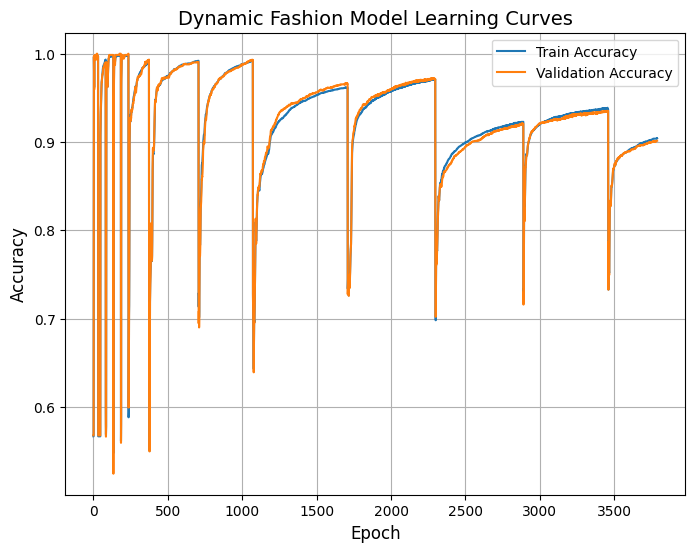

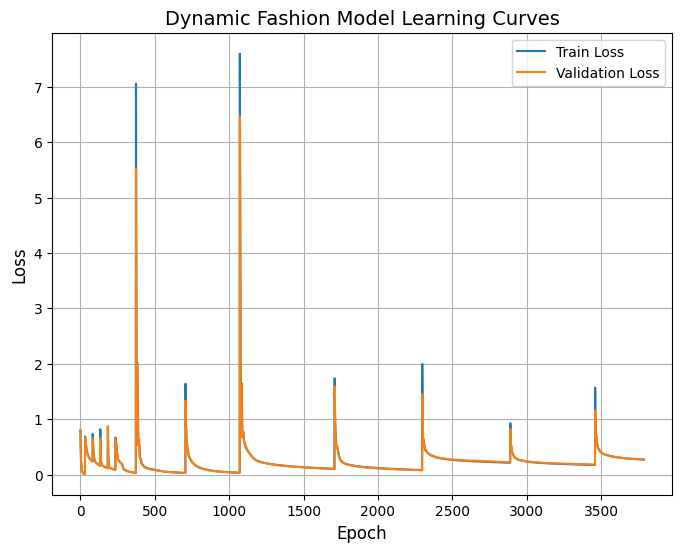

In [ ]:
plot_learning_curves(train_acc, test_acc, train_losses, val_losses, title="Dynamic Fashion Model Learning Curves")

In [ ]:
all_validation  = pd.concat(dfs_fashion_all_validation, axis=0).sample(frac=1).reset_index(drop=True)
X_validation_dynamic = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation_dynamic = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

all_test = pd.concat(dfs_fashion_all_test, axis=0).sample(frac=1).reset_index(drop=True)
X_test_fashion_dynamic = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_fashion_dynamic = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

model_fashion_dynamic.eval()
with torch.no_grad():
    val_preds_dynamic_fashion = model_fashion_dynamic(X_validation_dynamic).argmax(dim=1)
    val_accuracy_dynamic_fashion = accuracy_score(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu())
    val_preds_baseline_fashion = model_fashion(X_validation_fashion).argmax(dim=1)
    val_accuracy_baseline_fashion = accuracy_score(y_validation_fashion.cpu(), val_preds_baseline_fashion.cpu())

    test_preds_dynamic_fashion = model_fashion_dynamic(X_test_fashion_dynamic).argmax(dim=1)
    test_accuracy_dynamic_fashion = accuracy_score(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu())
    test_preds_baseline_fashion = model_fashion(X_test_fashion).argmax(dim=1)
    test_accuracy_baseline_fashion = accuracy_score(y_test_fashion.cpu(), test_preds_baseline_fashion.cpu())

    print("Classification Report for Dynamic Fashion Model (Validation):")
    print(classification_report(y_validation_dynamic.cpu(), val_preds_dynamic_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Baseline Fashion Model (Validation):")
    print(classification_report(y_validation_fashion.cpu(), val_preds_baseline_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Dynamic Fashion Model (Test):")
    print(classification_report(y_test_fashion_dynamic.cpu(), test_preds_dynamic_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

    print("Classification Report for Baseline Fashion Model (Test):")
    print(classification_report(y_test_fashion.cpu(), test_preds_baseline_fashion.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))


print(f"Dynamic Fashion Model Validation Accuracy: {val_accuracy_dynamic_fashion:.4f}")
print(f"Dynamic Fashion Model Test Accuracy: {test_accuracy_dynamic_fashion:.4f}")
print(f"Baseline Fashion Model Validation Accuracy: {val_accuracy_baseline_fashion:.4f}")
print(f"Baseline Fashion Model Test Accuracy: {test_accuracy_baseline_fashion:.4f}")


Dynamic Fashion Model Validation Accuracy: 0.9015
Dynamic Fashion Model Test Accuracy: 0.8361
Baseline Fashion Model Validation Accuracy: 0.9503
Baseline Fashion Model Test Accuracy: 0.8580


In [ ]:
input_dim_cov = X_train_cov.shape[1]
activation_cov = optimal_params_cov_dynamic['activation']
model_cov_dynamic = DynamicMLP(input_dim_cov).to(device)
optimizer_cov_dynamic = torch.optim.Adam(model_cov_dynamic.parameters(), lr=optimal_params_cov_dynamic['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, val_losses = train_complex_model(model_cov_dynamic, optimizer_cov_dynamic, criterion, optimal_params_cov_dynamic, dfs_cov_all_train, dfs_cov_all_validation, epochs=6000)

model_cov_dynamic.print_structure()

Goal classes to achieve (last index): 6
Initial training with classes: [np.int64(0), np.int64(1)], Train size: 6014, Test size: 2611
[train] Overfitting detected at epoch 1186. train_loss=0.0200, val_loss=0.0200, gap=-0.0001
[train] Adding neurons to prevent overfitting.
Added neurons to layer 0, new size: 2
Output layer updated to 2 -> 2
[train] Overfitting detected at epoch 2674. train_loss=0.0395, val_loss=0.0389, gap=-0.0006
[train] Adding neurons to prevent overfitting.
Added neurons to layer 0, new size: 4
Output layer updated to 4 -> 2
[train] Overfitting detected at epoch 3634. train_loss=0.0368, val_loss=0.0362, gap=-0.0006
[train] Adding neurons to prevent overfitting.
Added neurons to layer 0, new size: 8
Output layer updated to 8 -> 2
[train] Overfitting detected at epoch 4487. train_loss=0.0268, val_loss=0.0263, gap=-0.0005
[train] Adding neurons to prevent overfitting.
Added neurons to layer 0, new size: 16
Output layer updated to 16 -> 2
[train] Overfitting detected at e

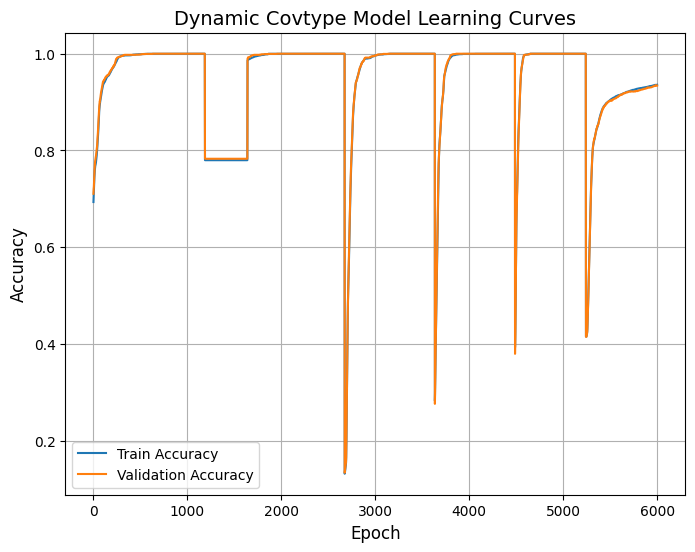

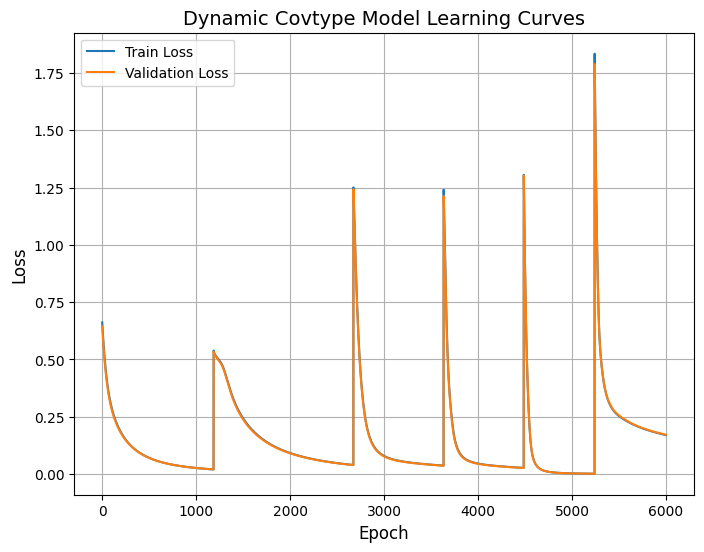

In [53]:
plot_learning_curves(train_acc, test_acc, train_losses, val_losses, title="Dynamic Covtype Model Learning Curves")

In [ ]:
all_validation  = pd.concat(dfs_cov_all_validation, axis=0).sample(frac=1).reset_index(drop=True)
X_validation = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)

all_test = pd.concat(df_cov_all_test, axis=0).sample(frac=1).reset_index(drop=True)
X_test_cov = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_cov = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

model_cov_dynamic.eval()
with torch.no_grad():
    val_preds_dynamic_cov = model_cov_dynamic(X_validation).argmax(dim=1)
    val_accuracy_dynamic_cov = accuracy_score(y_validation.cpu(), val_preds_dynamic_cov.cpu())
    val_preds_baseline_cov = model_cov(X_validation_cov).argmax(dim=1)
    val_accuracy_baseline_cov = accuracy_score(y_validation_cov.cpu(), val_preds_baseline_cov.cpu())

    test_preds_dynamic_cov = model_cov_dynamic(X_test_cov).argmax(dim=1)
    test_accuracy_dynamic_cov = accuracy_score(y_test_cov.cpu(), test_preds_dynamic_cov.cpu())
    test_preds_baseline_cov = model_cov(X_test_cov).argmax(dim=1)
    test_accuracy_baseline_cov = accuracy_score(y_test_cov.cpu(), test_preds_baseline_cov.cpu())

    print("Classification Report for Dynamic Covtype Model (Validation):")
    print(classification_report(y_validation.cpu(), val_preds_dynamic_cov.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_covtype))]))

    print("Classification Report for Baseline Covtype Model (Validation):")
    print(classification_report(y_validation_cov.cpu(), val_preds_baseline_cov.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_covtype))]))

    print("Classification Report for Dynamic Covtype Model (Test):")
    print(classification_report(y_test_cov.cpu(), test_preds_dynamic_cov.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_covtype))]))

    print("Classification Report for Baseline Covtype Model (Test):")
    print(classification_report(y_test_cov.cpu(), test_preds_baseline_cov.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_covtype))]))


print(f"Dynamic Covtype Model Validation Accuracy: {val_accuracy_dynamic_cov:.4f}")
print(f"Dynamic Covtype Model Test Accuracy: {test_accuracy_dynamic_cov:.4f}")
print(f"Baseline Covtype Model Validation Accuracy: {val_accuracy_baseline_cov:.4f}")
print(f"Baseline Covtype Model Test Accuracy: {test_accuracy_baseline_cov:.4f}")

Dynamic Covtype Model Validation Accuracy: 0.0482
Dynamic Covtype Model Test Accuracy: 0.0470


In [ ]:
input_dim_iris = X_train_iris.shape[1]
activation_iris = optimal_params_iris_dynamic['activation']
model_iris_dynamic = DynamicMLP(input_dim_iris).to(device)
optimizer_iris_dynamic = torch.optim.Adam(model_iris_dynamic.parameters(), lr=optimal_params_iris_dynamic['lr'])
criterion = nn.CrossEntropyLoss()
train_acc_iris, test_acc_iris, train_losses_iris, val_losses_iris = train_complex_model(model_iris_dynamic, optimizer_iris_dynamic, criterion, optimal_params_iris_dynamic, dfs_iris_all_train, dfs_iris_all_test, epochs=200, debug=True)

model_iris_dynamic.print_structure()

Goal classes to achieve (last index): 2
Initial training with classes: [np.int64(0), np.int64(1)], Train size: 35, Val size: 35


Training Progress:   1%|          | 2/200 [00:00<00:10, 18.37it/s]

Epoch 1/200 - Train Loss: 3.4738, Val Loss: 1.2210, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 0. train_loss=3.4738, val_loss=1.2210
Added neurons to layer 0, new size: 2
Output layer updated to 2 -> 2
Epoch 2/200 - Train Loss: 1.5336, Val Loss: 1.1692, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 1. train_loss=2.5037, val_loss=1.1951
Added neurons to layer 0, new size: 4
Output layer updated to 4 -> 2
Epoch 3/200 - Train Loss: 1.1676, Val Loss: 0.9220, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 2. train_loss=2.0583, val_loss=1.1040
Added neurons to layer 0, new size: 8
Output layer updated to 8 -> 2


Training Progress:   2%|▏         | 4/200 [00:00<00:11, 16.54it/s]

Epoch 4/200 - Train Loss: 0.8833, Val Loss: 0.7493, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 3. train_loss=1.7645, val_loss=1.0154
Added neurons to layer 0, new size: 16
Output layer updated to 16 -> 2


Training Progress:   3%|▎         | 6/200 [00:00<00:11, 16.37it/s]

Epoch 5/200 - Train Loss: 0.8341, Val Loss: 0.7299, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 4. train_loss=1.5785, val_loss=0.9583
Added neurons to layer 0, new size: 32
Output layer updated to 32 -> 2
Epoch 6/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 7/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143


Training Progress:   5%|▌         | 10/200 [00:00<00:07, 24.29it/s]

Epoch 8/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 9/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 10/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 11/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 12/200 - Train Loss: 0.9242, Val Loss: 0.7813, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 11. train_loss=0.9242, val_loss=0.7813
Added neurons to layer 0, new size: 64
Output layer updated to 64 -> 2
Epoch 13/200 - Train Loss: 0.8952, Val Loss: 0.7601, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 12. train_loss=0.9184, val_loss=0.7770
Added neurons to layer 0, new size: 128
Output layer updated to 128 -> 2


Training Progress:  10%|▉         | 19/200 [00:00<00:03, 45.40it/s]

Epoch 14/200 - Train Loss: 0.9915, Val Loss: 0.7951, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 15/200 - Train Loss: 0.9915, Val Loss: 0.7951, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 14. train_loss=0.9454, val_loss=0.7826
Added neurons to layer 0, new size: 256
Output layer updated to 256 -> 2
Epoch 16/200 - Train Loss: 0.9251, Val Loss: 0.7773, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 15. train_loss=0.9455, val_loss=0.7818
Added neurons to layer 0, new size: 512
Output layer updated to 512 -> 2
Epoch 17/200 - Train Loss: 0.9867, Val Loss: 0.8111, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 16. train_loss=0.9580, val_loss=0.7877
[train] Model structure changed: added neurons. Hidden layers: 2
Epoch 18/200 - Train Loss: 0.8811, Val Loss: 0.7079, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 17. train_loss=0.9552, val_loss=0.7773
Added neurons to layer 1, new size: 2

Training Progress:  16%|█▌        | 32/200 [00:00<00:02, 71.12it/s]

Epoch 29/200 - Train Loss: 0.7778, Val Loss: 0.7079, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 28. train_loss=0.7915, val_loss=0.7102
Added neurons to layer 1, new size: 16
Output layer updated to 16 -> 2
Epoch 30/200 - Train Loss: 0.8647, Val Loss: 0.7278, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 29. train_loss=0.8089, val_loss=0.7141
Added neurons to layer 1, new size: 32
Output layer updated to 32 -> 2
Epoch 31/200 - Train Loss: 0.7778, Val Loss: 0.7079, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 30. train_loss=0.8089, val_loss=0.7141
Added neurons to layer 1, new size: 64
Output layer updated to 64 -> 2
Epoch 32/200 - Train Loss: 0.8522, Val Loss: 0.7216, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 31. train_loss=0.8237, val_loss=0.7169
Added neurons to layer 1, new size: 128
Output layer updated to 128 -> 2
Epoch 33/200 - Train Loss: 0.7778, Val Loss: 0.707

Training Progress:  20%|██        | 40/200 [00:00<00:02, 72.08it/s]

Epoch 37/200 - Train Loss: 0.7311, Val Loss: 0.6930, Train Acc: 0.3429, Val Acc: 0.5143
Epoch 38/200 - Train Loss: 0.6947, Val Loss: 0.7000, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 39/200 - Train Loss: 0.6685, Val Loss: 0.7153, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 40/200 - Train Loss: 0.6521, Val Loss: 0.7371, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 41/200 - Train Loss: 0.6443, Val Loss: 0.7626, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 42/200 - Train Loss: 0.6431, Val Loss: 0.7886, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 43/200 - Train Loss: 0.6464, Val Loss: 0.8123, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 44/200 - Train Loss: 0.6518, Val Loss: 0.8312, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 45/200 - Train Loss: 0.6572, Val Loss: 0.8439, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 46/200 - Train Loss: 0.6613, Val Loss: 0.8501, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 47/200 - Train Loss: 0.6634, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
[train] Underfitting detected at

Training Progress:  26%|██▌       | 51/200 [00:00<00:01, 80.06it/s]

Epoch 48/200 - Train Loss: 0.6433, Val Loss: 8.5090, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 47. train_loss=0.6554, val_loss=2.3769
Added neurons to layer 2, new size: 4
Output layer updated to 4 -> 2
Epoch 49/200 - Train Loss: 1.3587, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
[train] Underfitting detected at epoch 48. train_loss=0.7968, val_loss=2.3807
Added neurons to layer 2, new size: 8
Output layer updated to 8 -> 2
Epoch 50/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
[train] Underfitting detected at epoch 49. train_loss=0.7981, val_loss=2.3819
Added neurons to layer 2, new size: 16
Output layer updated to 16 -> 2
Epoch 51/200 - Train Loss: 0.6580, Val Loss: 1.3058, Train Acc: 0.3429, Val Acc: 0.5143
[train] Underfitting detected at epoch 50. train_loss=0.7974, val_loss=2.4731
Added neurons to layer 2, new size: 32
Output layer updated to 32 -> 2
Epoch 52/200 - Train Loss: 0.6635, Val Loss: 0.8502, Tra

Training Progress:  31%|███       | 62/200 [00:00<00:01, 88.12it/s]

Epoch 57/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 58/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 59/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 60/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 61/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 62/200 - Train Loss: 0.6635, Val Loss: 0.8502, Train Acc: 0.6571, Val Acc: 0.4857
[train] Underfitting detected at epoch 61. train_loss=0.6635, val_loss=0.8502
Added neurons to layer 2, new size: 128
Output layer updated to 128 -> 2
Epoch 63/200 - Train Loss: 0.6494, Val Loss: 0.7166, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 64/200 - Train Loss: 0.6242, Val Loss: 0.6608, Train Acc: 0.6857, Val Acc: 0.5429
Epoch 65/200 - Train Loss: 0.6315, Val Loss: 0.6649, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 66/200 - Train Loss: 0.6226, Val Loss: 0.6848, Trai

Training Progress:  36%|███▌      | 71/200 [00:01<00:01, 86.48it/s]

Epoch 67/200 - Train Loss: 0.6112, Val Loss: 0.6951, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 68/200 - Train Loss: 0.6033, Val Loss: 0.6780, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 69/200 - Train Loss: 0.5916, Val Loss: 0.6372, Train Acc: 0.6571, Val Acc: 0.4857
Epoch 70/200 - Train Loss: 0.5753, Val Loss: 0.5971, Train Acc: 0.8000, Val Acc: 0.6000
Epoch 71/200 - Train Loss: 0.5585, Val Loss: 0.5867, Train Acc: 0.7143, Val Acc: 0.5714
Epoch 72/200 - Train Loss: 0.5349, Val Loss: 0.5725, Train Acc: 0.7143, Val Acc: 0.5714
Epoch 73/200 - Train Loss: 0.5068, Val Loss: 0.5016, Train Acc: 0.8857, Val Acc: 0.8857
Epoch 74/200 - Train Loss: 0.4744, Val Loss: 0.4768, Train Acc: 0.8857, Val Acc: 0.8286
Epoch 75/200 - Train Loss: 0.4434, Val Loss: 0.3877, Train Acc: 0.8286, Val Acc: 1.0000
Epoch 76/200 - Train Loss: 0.4599, Val Loss: 0.7092, Train Acc: 0.6857, Val Acc: 0.5143


Training Progress:  41%|████      | 82/200 [00:01<00:01, 92.88it/s]

Epoch 77/200 - Train Loss: 0.5535, Val Loss: 0.4112, Train Acc: 0.9143, Val Acc: 0.9429
Epoch 78/200 - Train Loss: 0.3928, Val Loss: 0.4293, Train Acc: 0.6286, Val Acc: 0.6857
Epoch 79/200 - Train Loss: 0.6261, Val Loss: 0.3530, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 80/200 - Train Loss: 0.3667, Val Loss: 0.6334, Train Acc: 0.7429, Val Acc: 0.5714
Epoch 81/200 - Train Loss: 0.5022, Val Loss: 0.5047, Train Acc: 0.8571, Val Acc: 0.7429
Epoch 82/200 - Train Loss: 0.4224, Val Loss: 0.2843, Train Acc: 0.8286, Val Acc: 1.0000
Epoch 83/200 - Train Loss: 0.3979, Val Loss: 0.2906, Train Acc: 0.8286, Val Acc: 1.0000
Epoch 84/200 - Train Loss: 0.4311, Val Loss: 0.3417, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 85/200 - Train Loss: 0.3491, Val Loss: 0.5072, Train Acc: 0.8571, Val Acc: 0.7429
Epoch 86/200 - Train Loss: 0.4214, Val Loss: 0.3621, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 87/200 - Train Loss: 0.3480, Val Loss: 0.2433, Train Acc: 0.8571, Val Acc: 1.0000
Epoch 88/200 - Train Loss: 0.357

Training Progress:  46%|████▋     | 93/200 [00:01<00:01, 97.45it/s]

Epoch 89/200 - Train Loss: 0.3632, Val Loss: 0.2903, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 90/200 - Train Loss: 0.3214, Val Loss: 0.4113, Train Acc: 0.8857, Val Acc: 0.8857
Epoch 91/200 - Train Loss: 0.3618, Val Loss: 0.3255, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 92/200 - Train Loss: 0.3235, Val Loss: 0.2146, Train Acc: 0.9143, Val Acc: 1.0000
Epoch 93/200 - Train Loss: 0.3288, Val Loss: 0.2054, Train Acc: 0.8857, Val Acc: 1.0000
Epoch 94/200 - Train Loss: 0.3453, Val Loss: 0.2548, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 95/200 - Train Loss: 0.3034, Val Loss: 0.3655, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 96/200 - Train Loss: 0.3344, Val Loss: 0.3217, Train Acc: 0.9714, Val Acc: 0.9429
Epoch 97/200 - Train Loss: 0.3153, Val Loss: 0.2152, Train Acc: 0.9143, Val Acc: 1.0000
Epoch 98/200 - Train Loss: 0.3047, Val Loss: 0.1925, Train Acc: 0.9143, Val Acc: 1.0000


Training Progress:  52%|█████▏    | 104/200 [00:01<00:00, 99.69it/s]

Epoch 99/200 - Train Loss: 0.3221, Val Loss: 0.2357, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 100/200 - Train Loss: 0.2930, Val Loss: 0.3255, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 101/200 - Train Loss: 0.3126, Val Loss: 0.3013, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 102/200 - Train Loss: 0.3029, Val Loss: 0.2151, Train Acc: 0.9429, Val Acc: 1.0000
Epoch 103/200 - Train Loss: 0.2920, Val Loss: 0.1927, Train Acc: 0.9143, Val Acc: 1.0000
Epoch 104/200 - Train Loss: 0.3055, Val Loss: 0.2306, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 105/200 - Train Loss: 0.2854, Val Loss: 0.2958, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 106/200 - Train Loss: 0.2978, Val Loss: 0.2746, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 107/200 - Train Loss: 0.2905, Val Loss: 0.2108, Train Acc: 0.9714, Val Acc: 1.0000
Epoch 108/200 - Train Loss: 0.2850, Val Loss: 0.1934, Train Acc: 0.9143, Val Acc: 1.0000
Epoch 109/200 - Train Loss: 0.2938, Val Loss: 0.2285, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 110/200 - Train 

Training Progress:  57%|█████▊    | 115/200 [00:01<00:00, 102.67it/s]

Epoch 111/200 - Train Loss: 0.2867, Val Loss: 0.2518, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 112/200 - Train Loss: 0.2816, Val Loss: 0.2084, Train Acc: 0.9714, Val Acc: 1.0000
Epoch 113/200 - Train Loss: 0.2802, Val Loss: 0.2026, Train Acc: 0.9714, Val Acc: 1.0000
Epoch 114/200 - Train Loss: 0.2813, Val Loss: 0.2328, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 115/200 - Train Loss: 0.2770, Val Loss: 0.2548, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 116/200 - Train Loss: 0.2800, Val Loss: 0.2324, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 117/200 - Train Loss: 0.2759, Val Loss: 0.2048, Train Acc: 0.9714, Val Acc: 1.0000
Epoch 118/200 - Train Loss: 0.2769, Val Loss: 0.2126, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 119/200 - Train Loss: 0.2748, Val Loss: 0.2327, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 120/200 - Train Loss: 0.2744, Val Loss: 0.2377, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 121/200 - Train Loss: 0.2746, Val Loss: 0.2201, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 122/200 - Train

Training Progress:  63%|██████▎   | 126/200 [00:01<00:00, 101.46it/s]

Epoch 123/200 - Train Loss: 0.2735, Val Loss: 0.2126, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 124/200 - Train Loss: 0.2724, Val Loss: 0.2289, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 125/200 - Train Loss: 0.2720, Val Loss: 0.2325, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 126/200 - Train Loss: 0.2719, Val Loss: 0.2180, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 127/200 - Train Loss: 0.2708, Val Loss: 0.2086, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 128/200 - Train Loss: 0.2711, Val Loss: 0.2152, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 129/200 - Train Loss: 0.2702, Val Loss: 0.2281, Train Acc: 0.9429, Val Acc: 0.9714


Training Progress:  68%|██████▊   | 137/200 [00:01<00:00, 89.86it/s] 

Epoch 130/200 - Train Loss: 0.2701, Val Loss: 0.2265, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 131/200 - Train Loss: 0.2697, Val Loss: 0.2138, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 132/200 - Train Loss: 0.2692, Val Loss: 0.2103, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 133/200 - Train Loss: 0.2691, Val Loss: 0.2196, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 134/200 - Train Loss: 0.2685, Val Loss: 0.2267, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 135/200 - Train Loss: 0.2685, Val Loss: 0.2192, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 136/200 - Train Loss: 0.2678, Val Loss: 0.2109, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 137/200 - Train Loss: 0.2678, Val Loss: 0.2143, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 138/200 - Train Loss: 0.2673, Val Loss: 0.2231, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 139/200 - Train Loss: 0.2672, Val Loss: 0.2215, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 140/200 - Train Loss: 0.2668, Val Loss: 0.2129, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 141/200 - Train

Training Progress:  74%|███████▎  | 147/200 [00:01<00:00, 86.24it/s]

Epoch 146/200 - Train Loss: 0.2653, Val Loss: 0.2175, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 147/200 - Train Loss: 0.2649, Val Loss: 0.2200, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 148/200 - Train Loss: 0.2648, Val Loss: 0.2144, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 149/200 - Train Loss: 0.2645, Val Loss: 0.2118, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 150/200 - Train Loss: 0.2643, Val Loss: 0.2164, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 151/200 - Train Loss: 0.2640, Val Loss: 0.2186, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 152/200 - Train Loss: 0.2638, Val Loss: 0.2138, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 153/200 - Train Loss: 0.2636, Val Loss: 0.2119, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 154/200 - Train Loss: 0.2634, Val Loss: 0.2160, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 155/200 - Train Loss: 0.2631, Val Loss: 0.2171, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 156/200 - Train Loss: 0.2629, Val Loss: 0.2128, Train Acc: 0.9429, Val Acc: 0.9714


Training Progress:  78%|███████▊  | 157/200 [00:02<00:00, 89.64it/s]

Epoch 157/200 - Train Loss: 0.2627, Val Loss: 0.2122, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 158/200 - Train Loss: 0.2625, Val Loss: 0.2159, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 159/200 - Train Loss: 0.2623, Val Loss: 0.2154, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 160/200 - Train Loss: 0.2621, Val Loss: 0.2118, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 161/200 - Train Loss: 0.2619, Val Loss: 0.2128, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 162/200 - Train Loss: 0.2617, Val Loss: 0.2155, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 163/200 - Train Loss: 0.2615, Val Loss: 0.2135, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 164/200 - Train Loss: 0.2613, Val Loss: 0.2113, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 165/200 - Train Loss: 0.2611, Val Loss: 0.2136, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 166/200 - Train Loss: 0.2609, Val Loss: 0.2145, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 167/200 - Train Loss: 0.2607, Val Loss: 0.2118, Train Acc: 0.9429, Val Acc: 0.9714


Training Progress:  84%|████████▍ | 169/200 [00:02<00:00, 95.91it/s]

Epoch 168/200 - Train Loss: 0.2605, Val Loss: 0.2118, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 169/200 - Train Loss: 0.2603, Val Loss: 0.2139, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 170/200 - Train Loss: 0.2601, Val Loss: 0.2126, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 171/200 - Train Loss: 0.2600, Val Loss: 0.2110, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 172/200 - Train Loss: 0.2598, Val Loss: 0.2126, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 173/200 - Train Loss: 0.2596, Val Loss: 0.2117, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 174/200 - Train Loss: 0.2594, Val Loss: 0.2116, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 175/200 - Train Loss: 0.2592, Val Loss: 0.2122, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 176/200 - Train Loss: 0.2591, Val Loss: 0.2117, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 177/200 - Train Loss: 0.2589, Val Loss: 0.2112, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 178/200 - Train Loss: 0.2587, Val Loss: 0.1899, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 179/200 - Train

Training Progress:  90%|█████████ | 180/200 [00:02<00:00, 98.91it/s]

Epoch 180/200 - Train Loss: 0.2627, Val Loss: 0.1858, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 181/200 - Train Loss: 0.2640, Val Loss: 0.2147, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 182/200 - Train Loss: 0.2591, Val Loss: 0.1897, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 183/200 - Train Loss: 0.2618, Val Loss: 0.2222, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 184/200 - Train Loss: 0.2613, Val Loss: 0.1853, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 185/200 - Train Loss: 0.2635, Val Loss: 0.2181, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 186/200 - Train Loss: 0.2599, Val Loss: 0.1892, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 187/200 - Train Loss: 0.2614, Val Loss: 0.2190, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 188/200 - Train Loss: 0.2601, Val Loss: 0.1852, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 189/200 - Train Loss: 0.2630, Val Loss: 0.2209, Train Acc: 0.9429, Val Acc: 0.9429


Training Progress: 100%|██████████| 200/200 [00:02<00:00, 83.26it/s] 

Epoch 190/200 - Train Loss: 0.2606, Val Loss: 0.1882, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 191/200 - Train Loss: 0.2612, Val Loss: 0.2168, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 192/200 - Train Loss: 0.2592, Val Loss: 0.1855, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 193/200 - Train Loss: 0.2623, Val Loss: 0.2222, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 194/200 - Train Loss: 0.2610, Val Loss: 0.1869, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 195/200 - Train Loss: 0.2613, Val Loss: 0.2160, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 196/200 - Train Loss: 0.2588, Val Loss: 0.1860, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 197/200 - Train Loss: 0.2615, Val Loss: 0.2215, Train Acc: 0.9429, Val Acc: 0.9429
Epoch 198/200 - Train Loss: 0.2608, Val Loss: 0.1856, Train Acc: 0.9714, Val Acc: 0.9714
Epoch 199/200 - Train Loss: 0.2615, Val Loss: 0.2166, Train Acc: 0.9429, Val Acc: 0.9714
Epoch 200/200 - Train Loss: 0.2588, Val Loss: 0.1864, Train Acc: 0.9714, Val Acc: 0.9714
Training finished. Re

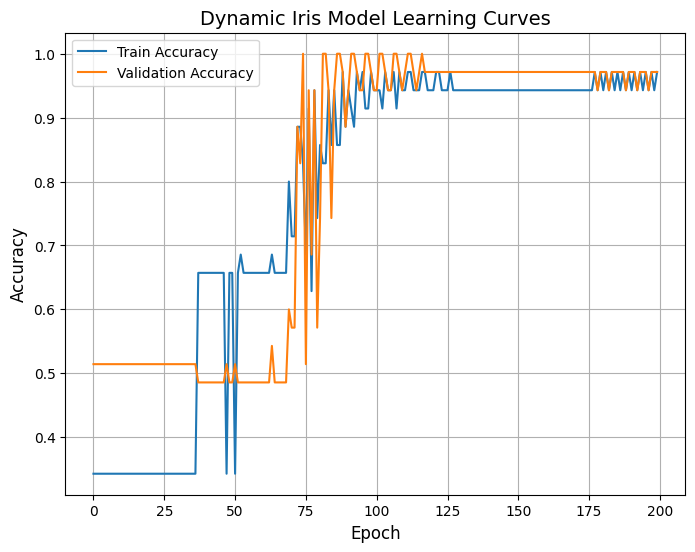

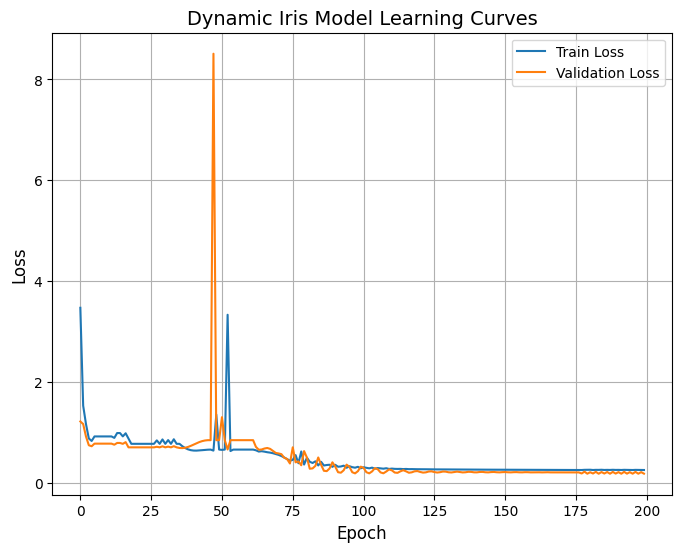

In [44]:
plot_learning_curves(train_acc_iris, test_acc_iris, train_losses_iris, val_losses_iris, title="Dynamic Iris Model Learning Curves")

In [ ]:
all_test = pd.concat(dfs_iris_all_test, axis=0).sample(frac=1).reset_index(drop=True)
X_test_iris = torch.tensor(all_test.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_iris = torch.tensor(all_test['label'].values, dtype=torch.long).to(device)

model_iris_dynamic.eval()
with torch.no_grad():
    test_preds_dynamic_iris = model_iris_dynamic(X_test_iris).argmax(dim=1)
    test_accuracy_dynamic_iris = accuracy_score(y_test_iris.cpu(), test_preds_dynamic_iris.cpu())
    test_preds_baseline_iris = model_iris(X_test_iris).argmax(dim=1)
    test_accuracy_baseline_iris = accuracy_score(y_test_iris.cpu(), test_preds_baseline_iris.cpu())

    print("Classification Report for Dynamic Iris Model (Test):")
    print(classification_report(y_test_iris.cpu(), test_preds_dynamic_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))

    print("Classification Report for Baseline Iris Model (Test):")
    print(classification_report(y_test_iris.cpu(), test_preds_baseline_iris.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_iris))]))

print(f"Dynamic Iris Model Test Accuracy: {test_accuracy_dynamic_iris:.4f}")
print(f"Baseline Iris Model Test Accuracy: {test_accuracy_baseline_iris:.4f}")

### Note on dynamic model evaluation
The dynamic model uses remapped label indices (0..N-1) stored in `y_test_cov_scaled` and the training/validation data. Previously the code attempted to remap `y_test_cov_scaled` again using `label_map_cov`, which double-mapped labels and produced incorrect label alignment. We now use `y_test_cov_scaled` directly as it already contains the mapped indices. `reverse_label_map_cov` is used only to display the original class labels in the report's `target_names` in the correct order.

In [ ]:
### Training for fashion mnist
input_dim_fashion = X_train_fashion.shape[1]
activation_fashion = optimal_params_fashion_dynamic['activation']
model_fashion_dynamic = DynamicMLP(input_dim_fashion).to(device)
optimizer_fashion_dynamic = torch.optim.Adam(model_fashion_dynamic.parameters(), lr=optimal_params_fashion_dynamic['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_complex_model(model_fashion_dynamic, optimizer_fashion_dynamic, criterion, optimal_params_fashion_dynamic, dfs_fashion_all_train, dfs_fashion_all_validation, epochs=1000)
plot_learning_curves(train_acc, test_acc, title="Dynamic Fashion MNIST Model Learning Curves")
model_fashion_dynamic.print_structure()

In [ ]:
# classificatrion report for fashion baseline and dynamic
model_fashion.eval()
with torch.no_grad(): 
    test_preds = model_fashion(X_test_fashion).argmax(dim=1)
    print("Classification Report for Baseline Fashion MNIST Model:")
    print(classification_report(y_test_fashion.cpu(), test_preds.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

model_fashion_dynamic.eval()
with torch.no_grad():
    test_preds = model_fashion_dynamic(X_test_fashion).argmax(dim=1)
    print("Classification Report for Dynamic Fashion MNIST Model:")
    print(classification_report(y_test_fashion.cpu(), test_preds.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))


### Evaluation of baseline models and dynamic models

In [ ]:
runs = 3
results = {
    'baseline': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []},
    'dynamic': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
}

# Use existing dataset arrays and DataFrames available in the notebook
feature_cols_cov = df_covtype.drop('Cover_Type', axis=1).columns
num_classes_cov = len(df_covtype['Cover_Type'].unique())

input_dim = None
output_dim = None
hidden_layers = optimal_params_cov_dynamic['hidden_layers']
activation = optimal_params_cov_dynamic['activation']
lr = optimal_params_cov_dynamic['lr']
epochs = 200  # per-run training epochs for baseline; dynamic will use same value for max epochs

for run in range(runs):
    print(f"Run {run+1}/{runs}")
    # different seed for different train/validation splits
    seed = 42 + run

    # --- Prepare per-run Covtype splits and scalers ---
    X_train_cov_init, X_test_cov_init, y_train_cov_init, y_test_cov_init = train_test_split(
        X_cov_type, y_cov_type, test_size=0.3, random_state=seed)
    X_train_cov_final, X_validation_cov_final, y_train_cov_final, y_validation_cov_final = train_test_split(
        X_train_cov_init, y_train_cov_init, test_size=0.3, random_state=seed)

    scaler = StandardScaler()
    X_train_cov_scaled = scaler.fit_transform(X_train_cov_final)
    X_validation_cov_scaled = scaler.transform(X_validation_cov_final)

    # build per-run DataFrames (same format as the rest of the notebook)
    df_train_cov_run = pd.DataFrame(X_train_cov_scaled, columns=feature_cols_cov)
    df_train_cov_run['label'] = y_train_cov_final
    df_validation_cov_run = pd.DataFrame(X_validation_cov_scaled, columns=feature_cols_cov)
    df_validation_cov_run['label'] = y_validation_cov_final

    # create per-class lists required by the dynamic training routine
    dfs_cov_all_train_run = [df_train_cov_run[df_train_cov_run['label'] == i].copy() for i in range(num_classes_cov)]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == i].copy() for i in range(num_classes_cov)]

    # sort classes by size and relabel (keeps same logic as earlier in the notebook)
    dfs_cov_all_train_run.sort(key=lambda x: len(x), reverse=False)
    sorted_label_order_cov = [int(df['label'].iloc[0]) if len(df) > 0 else -1 for df in dfs_cov_all_train_run]
    # filter out empty classes (if any) and create mapping
    non_empty = [lbl for lbl in sorted_label_order_cov if lbl != -1]
    label_map_cov = dict(zip(non_empty, range(len(non_empty))))
    dfs_cov_all_train_run = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train_run if len(df) > 0]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in non_empty]

    # create tensors for baseline training / validation
    X_train_cov_run = torch.tensor(df_train_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_train_cov_run = torch.tensor(df_train_cov_run['label'].values, dtype=torch.long).to(device)
    X_validation_cov_run = torch.tensor(df_validation_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_cov_run = torch.tensor(df_validation_cov_run['label'].values, dtype=torch.long).to(device)

    input_dim = X_train_cov_run.shape[1]
    output_dim = len(torch.unique(y_train_cov_run))

    # --- Baseline SimpleMLP trained on per-run tensors ---
    baseline_model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
    opt_b = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    t0 = time.time()
    baseline_model.train()
    for ep in range(epochs):
        opt_b.zero_grad()
        out = baseline_model(X_train_cov_run)
        loss = crit(out, y_train_cov_run)
        loss.backward()
        opt_b.step()
    t1 = time.time()

    baseline_model.eval()
    with torch.no_grad():
        val_preds = baseline_model(X_validation_cov_run).argmax(dim=1)
        acc = accuracy_score(y_validation_cov_run.cpu(), val_preds.cpu())
        prec = precision_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        rec = recall_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        f1 = f1_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)

    results['baseline']['accuracy'].append(acc)
    results['baseline']['precision'].append(prec)
    results['baseline']['recall'].append(rec)
    results['baseline']['f1'].append(f1)
    results['baseline']['time'].append(t1 - t0)

    print(f"Baseline run {run+1}: val_acc={acc:.4f}, prec={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}, time={t1-t0:.2f}s")

    # --- Dynamic model using per-run per-class DataFrames ---
    dyn_model = DynamicMLP(input_dim).to(device)
    opt_d = torch.optim.Adam(dyn_model.parameters(), lr=lr)

    t0 = time.time()
    # train_complex_model will operate on per-class DataFrames
    train_acc_list, val_acc_list = train_complex_model(
        dyn_model, opt_d, crit, optimal_params_cov_dynamic,
        dfs_cov_all_train_run, dfs_cov_all_validation_run,
        label='label', epochs=epochs
    )
    t1 = time.time()

    # evaluate dynamic model on the same validation tensors
    dyn_model.eval()
    with torch.no_grad():
        val_preds_d = dyn_model(X_validation_cov_run).argmax(dim=1)
        acc_d = accuracy_score(y_validation_cov_run.cpu(), val_preds_d.cpu())
        prec_d = precision_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        rec_d = recall_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        f1_d = f1_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)

    results['dynamic']['accuracy'].append(acc_d)
    results['dynamic']['precision'].append(prec_d)
    results['dynamic']['recall'].append(rec_d)
    results['dynamic']['f1'].append(f1_d)
    results['dynamic']['time'].append(t1 - t0)

    print(f"Dynamic run {run+1}: val_acc={acc_d:.4f}, prec={prec_d:.4f}, recall={rec_d:.4f}, f1={f1_d:.4f}, time={t1-t0:.2f}s")
    print("---")

# End runs
print('\nAll runs complete.')


In [ ]:
# Ensure results directory exists
os.makedirs(results_dir, exist_ok=True)

# build summary DataFrame
rows = []
for model_name in ['baseline', 'dynamic']:
    row = {'model': model_name}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'time']:
        vals = results[model_name][metric]
        row[f'{metric}_mean'] = np.mean(vals) if len(vals) > 0 else np.nan
        row[f'{metric}_std'] = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
    rows.append(row)

summary_df = pd.DataFrame(rows)
# nicer ordering
cols = ['model'] + [c for m in ['accuracy', 'precision', 'recall', 'f1', 'time'] for c in (f'{m}_mean', f'{m}_std')]
summary_df = summary_df[cols]
print('\nCross-validation summary (means and std):')
print(summary_df)

# Save per-run results and summary to CSV
per_run_rows = []
for model_name in ['baseline', 'dynamic']:
    for i in range(len(results[model_name]['accuracy'])):
        per_run_rows.append({
            'model': model_name,
            'run': i+1,
            'accuracy': results[model_name]['accuracy'][i],
            'precision': results[model_name]['precision'][i],
            'recall': results[model_name]['recall'][i],
            'f1': results[model_name]['f1'][i],
            'time': results[model_name]['time'][i]
        })
per_run_df = pd.DataFrame(per_run_rows)
per_run_csv = os.path.join(results_dir, 'evaluation_per_run.csv')
per_run_df.to_csv(per_run_csv, index=False)
print(f"Per-run results saved to: {per_run_csv}")

summary_csv = os.path.join(results_dir, 'evaluation_summary.csv')
summary_df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

# Also append to a master evaluation file (creates if not present)
master_csv = os.path.join(results_dir, 'evaluation_results.csv')
# create master file with headers if it doesn't exist
if not os.path.exists(master_csv):
    summary_df.to_csv(master_csv, index=False)
else:
    # append with a header only if file is empty
    summary_df.to_csv(master_csv, mode='a', header=False, index=False)
print(f"Appended summary to master file: {master_csv}")

# Final classification reports on the shared TEST set
print('\nClassification reports on shared TEST set:')
# Baseline final model: retrain baseline on full training+validation (to make final test evaluation fair)
print('\nRetraining baseline on train+validation and evaluating on TEST set...')
# combine training and validation into one set (use last run's splits as representative)
X_full_train = torch.cat([X_train_cov_run, X_validation_cov_run], dim=0)
Y_full_train = torch.cat([y_train_cov_run, y_validation_cov_run], dim=0)

final_baseline = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
opt_fb = torch.optim.Adam(final_baseline.parameters(), lr=lr)
final_baseline.train()
for ep in range(epochs):
    opt_fb.zero_grad()
    out = final_baseline(X_full_train)
    loss = crit(out, Y_full_train)
    loss.backward()
    opt_fb.step()
final_baseline.eval()
with torch.no_grad():
    test_preds_b = final_baseline(X_test_cov).argmax(dim=1)
print('\nBaseline TEST classification report:')
report_b = classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0))

# save baseline report
baseline_report_file = os.path.join(results_dir, 'baseline_test_classification_report.json')
with open(baseline_report_file, 'w') as f:
    json.dump(report_b, f, indent=2)
print(f"Baseline test classification report saved to: {baseline_report_file}")


In [ ]:
# Dynamic final model: retrain with train_complex_model on dfs_cov_all_train + dfs_cov_all_validation (the splits already used), then evaluate on same X_test_cov
print('\nTraining dynamic model on train+validation (per-class) and evaluating on TEST set...')
final_dynamic = DynamicMLP(input_dim).to(device)
opt_fd = torch.optim.Adam(final_dynamic.parameters(), lr=lr)
# train using the per-run per-class data we created earlier (dfs_cov_all_train_run/validation)
train_complex_model(final_dynamic, opt_fd, crit, optimal_params_cov_dynamic, dfs_cov_all_train_run, dfs_cov_all_validation_run, label='label', epochs=epochs)
final_dynamic.eval()
with torch.no_grad():
    test_preds_d = final_dynamic(X_test_cov).argmax(dim=1)
print('\nDynamic TEST classification report:')
report_d = classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0))

# save dynamic report
dynamic_report_file = os.path.join(results_dir, 'dynamic_test_classification_report.json')
with open(dynamic_report_file, 'w') as f:
    json.dump(report_d, f, indent=2)
print(f"Dynamic test classification report saved to: {dynamic_report_file}")

# Append a combined row to master CSV with timestamps and paths for artifacts
timestamp = pd.Timestamp.now().isoformat()
combined_row = {
    'timestamp': timestamp,
    'dataset': 'covtype',
    'runs': runs,
    'baseline_summary_path': summary_csv,
    'per_run_path': per_run_csv,
    'baseline_report': baseline_report_file,
    'dynamic_report': dynamic_report_file
}
combined_df = pd.DataFrame([combined_row])
master_meta_csv = os.path.join(results_dir, 'evaluation_runs_meta.csv')
if not os.path.exists(master_meta_csv):
    combined_df.to_csv(master_meta_csv, index=False)
else:
    combined_df.to_csv(master_meta_csv, mode='a', header=False, index=False)
print(f"Evaluation metadata appended to: {master_meta_csv}")


In [ ]:
summary_df